# Defect 분류

process_images.ipynb에서 전처리된 데이터로 결함 분류 모델을 학습한다. 간단한 CNN 모델을 구현하였다.

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
import pandas
import doctest
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
## 데이터 디렉토리
data_dir = '/home/kikim/data/materials/xray_20180330/dataset_20180511_212404/'

In [3]:
## 2번째 GPU 사용
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [4]:
## 데이터의 정규화를 위해 평균과 표준편차 계산

# N = 1000

# imgs = np.zeros((3, N, 256, 256, 3))
# for i, c in enumerate(['short', 'good', 'excessive']):
#     for j in range(N):
#         img = plt.imread(os.path.join(data_dir, 'train', c, '%05d.jpg' % j))
#         imgs[i, j , :, :, :] = img
        
# mean = np.mean(imgs[:])
# std = np.std(imgs[:])
# print(mean, std)


In [5]:
## 데이터 로딩

mean, std = 0.7471, 0.0896

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean, mean, mean], std=[std, std, std]),
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), 
                                     transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16, shuffle=True,
                                           num_workers=4)

classes = train_dataset.classes
classes

['excessive', 'good', 'short']

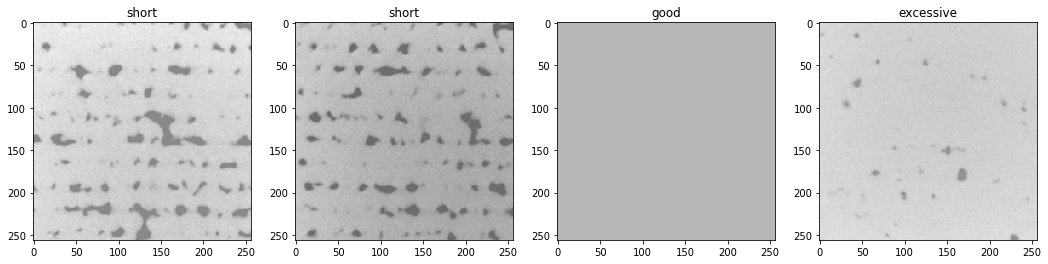

In [6]:
## 학습데이터 몇 개를 그려보자.

dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(18, 4))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)
    ax.imshow(images[i].permute([1,2,0]) * std  + mean)
    ax.set_title('%s' % classes[labels[i]])

In [7]:
## 좀 작은 모델

class Net01(nn.Module):
    def __init__(self):
        super(Net01, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        
#         self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        
#         self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        
#         self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
#         self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        
#         self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        
        self.fc1 = nn.Linear(64*64**2, 32)
#         self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1_1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv1_2(x)), 2)
        
#         x = F.relu(self.conv2_1(x))
#         x = F.max_pool2d(F.relu(self.conv2_2(x)), 2)
        
#         x = F.relu(self.conv3_1(x))
#         x = F.max_pool2d(F.relu(self.conv3_2(x)), 2)
        
#         x = F.relu(self.conv4_1(x))
#         x = F.relu(self.conv4_2(x))
#         x = F.max_pool2d(F.relu(self.conv4_3(x)), 2)
        
#         x = F.relu(self.conv5_1(x))
#         x = F.relu(self.conv5_2(x))
#         x = F.max_pool2d(F.relu(self.conv5_3(x)), 2)
        
#         print(x.size())
        
        x = x.view(-1, 64*64**2)
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = F.softmax(x, dim=0)
        return x


In [8]:
## 좀 더 큰 모델 

class Net02(nn.Module):
    def __init__(self):
        super(Net02, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        
#         self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        
#         self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
#         self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        
#         self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        
        self.fc1 = nn.Linear(128*64**2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.max_pool2d(F.relu(self.conv1_2(x)), 2)
        
        x = F.relu(self.conv2_1(x))
        x = F.max_pool2d(F.relu(self.conv2_2(x)), 2)
        
#         x = F.relu(self.conv3_1(x))
#         x = F.max_pool2d(F.relu(self.conv3_2(x)), 2)
        
#         x = F.relu(self.conv4_1(x))
#         x = F.relu(self.conv4_2(x))
#         x = F.max_pool2d(F.relu(self.conv4_3(x)), 2)
        
#         x = F.relu(self.conv5_1(x))
#         x = F.relu(self.conv5_2(x))
#         x = F.max_pool2d(F.relu(self.conv5_3(x)), 2)
        
#         print(x.size())
        
        x = x.view(-1, 128*64**2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = F.softmax(x, dim=0)
        return x


In [9]:
## 모델 생성하고 GPU로 올리기

net = Net02()

net.to(device)

Net02(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=524288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

In [10]:
## 오차 함수 설정
criterion = nn.CrossEntropyLoss().to(device)

## 학습 최적화 기법 설정
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

In [11]:
## Validation Set
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'valid'), 
                                     transform=data_transform)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=64, shuffle=False,
                                           num_workers=4)

In [12]:
## 학습 실행

start_time = datetime.datetime.now()
print(start_time)

for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
            running_loss = 0.0
            
    valid_loss = 0.0
    n_valid = 0
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
        valid_loss += loss.item()
        n_valid += 1
        
    print('[%d] valid_loss: %.3f' % (epoch + 1, valid_loss / n_valid))
            
print('Finished Training')
print(datetime.datetime.now() - start_time)

2018-05-19 02:47:07.487883
[1,   100] loss: 0.582
[1,   200] loss: 0.086
[1,   300] loss: 0.087
[1,   400] loss: 0.084
[1,   500] loss: 0.067
[1,   600] loss: 0.043
[1,   700] loss: 0.044
[1,   800] loss: 0.030
[1,   900] loss: 0.017
[1,  1000] loss: 0.033
[1,  1100] loss: 0.056
[1,  1200] loss: 0.029
[1,  1300] loss: 0.032
[1,  1400] loss: 0.003
[1,  1500] loss: 0.050
[1,  1600] loss: 0.101
[1,  1700] loss: 0.108
[1,  1800] loss: 0.006
[1] valid_loss: 0.036
[2,   100] loss: 0.061
[2,   200] loss: 0.023
[2,   300] loss: 0.018
[2,   400] loss: 0.013
[2,   500] loss: 0.026
[2,   600] loss: 0.008
[2,   700] loss: 0.006
[2,   800] loss: 0.015
[2,   900] loss: 0.007
[2,  1000] loss: 0.112
[2,  1100] loss: 0.029
[2,  1200] loss: 0.010
[2,  1300] loss: 0.108
[2,  1400] loss: 0.033
[2,  1500] loss: 0.027
[2,  1600] loss: 0.007
[2,  1700] loss: 0.005
[2,  1800] loss: 0.002
[2] valid_loss: 0.012
[3,   100] loss: 0.076
[3,   200] loss: 0.039
[3,   300] loss: 0.041
[3,   400] loss: 0.002
[3,   500

# 학습된 모델 검증

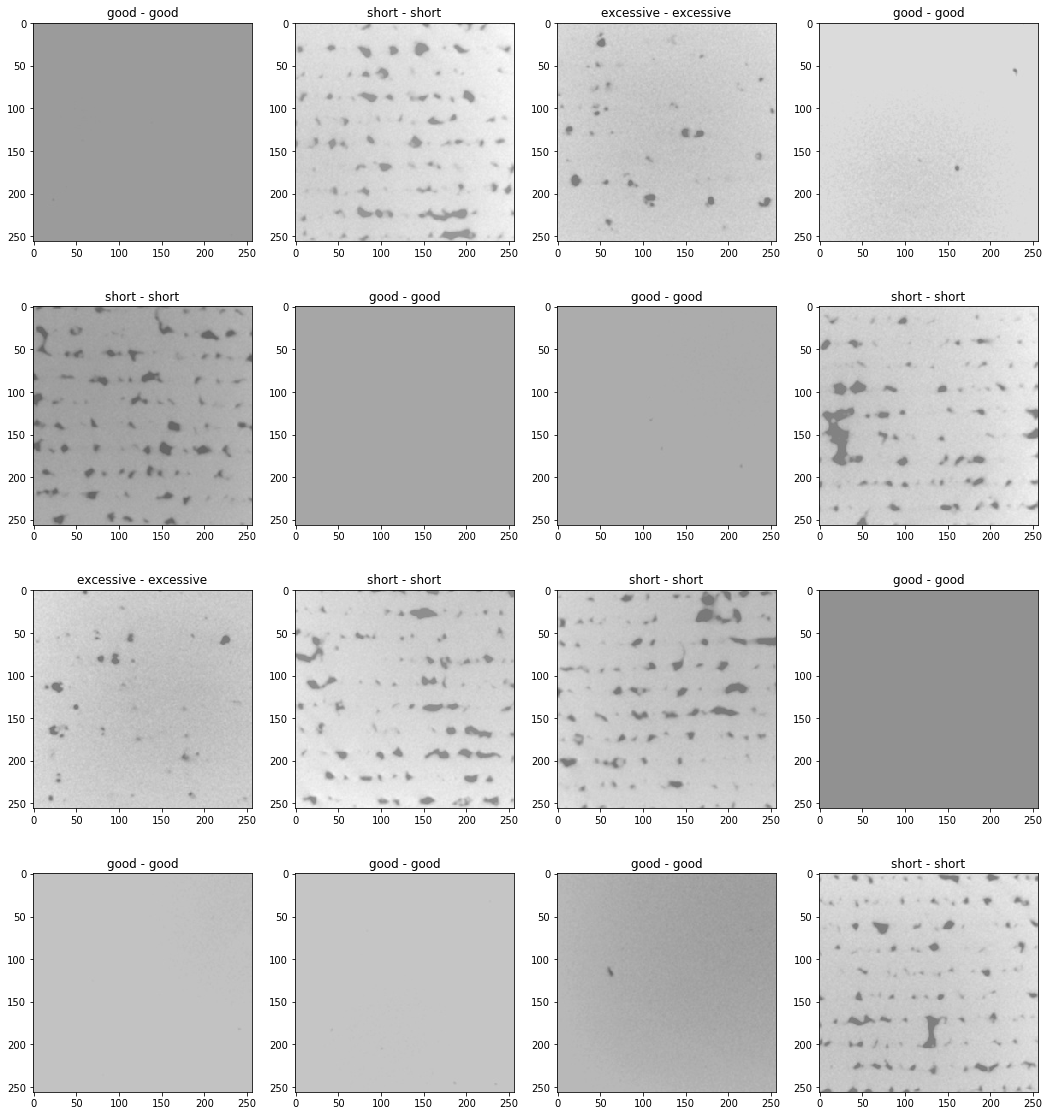

In [13]:
## 예측 결과를 출력해보자.

test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), 
                                    transform=data_transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=16, shuffle=True,
                                           num_workers=4)

dataiter = iter(test_loader)
images, labels = dataiter.next()

with torch.no_grad():
    outputs = net(images.to(device))
    
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(18,20))
for i in range(images.size(0)):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(images[i].permute([1,2,0]) * std  + mean)
    ax.set_title('%s - %s' % (classes[labels[i]], classes[predicted[i]]))

In [14]:
## 다양한 모델 성능 평가 클래스들

class Evaluator():
    '''모델 성능 평가 추상 클래스
    '''
    def check_labels(self, **kwargs):
        '''
        >>> ev = Evaluator()
        >>> ev.check_labels(**{'desired_labels':np.asarray([0,1,1]), 'predicted_labels':np.asarray([1,1,1])})
        ([0, 1, 1], [1, 1, 1])
        '''
        desired = self.check_list_arg('desired_labels', **kwargs)
        predicted = self.check_list_arg('predicted_labels', **kwargs)
        
        if len(desired) != len(predicted):
            raise Exception('desired_labels and predicted_labels should have same length, ' + 
                            'but %d vs %d' % len(desired), len(predicted))
        
        return desired, predicted
            

    def check_list_arg(self, arg_name, **kwargs):
        '''
        >>> ev = Evaluator()
        >>> ev.check_list_arg('a', **{'a':torch.Tensor([1,2,3])})
        [1, 2, 3]
        '''
        if arg_name not in kwargs:
            raise Exception('%s is necessary' % arg_name)
        
        if isinstance(kwargs[arg_name], torch.Tensor):
            return kwargs[arg_name].type(torch.IntTensor).tolist()
        
        if isinstance(kwargs[arg_name], np.ndarray):
            return list(kwargs[arg_name].flatten())
        
        if isinstance(kwargs[arg_name], list):
            return kwargs[arg_name]
        
        raise ValueError("%s is not list-like" % arg_name)
        

class EvaluatorAccuracy(Evaluator):
    '''정확도 계산
    kwargs:
    - desired_labels: 정답 클래스 인덱스
    - predicted_labels: 예측한 클래스 인덱스

    >>> evalAcc = EvaluatorAccuracy()
    >>> evalAcc.update(desired_labels=torch.tensor([1, 0, 2, 1, 0]), predicted_labels=torch.tensor([1, 1, 2, 0, 0]))
    >>> evalAcc.update(desired_labels=torch.tensor([0, 0, 1, 1, 2]), predicted_labels=torch.tensor([0, 0, 1, 2, 2]))
    >>> evalAcc.get_result()
    0.7

    '''
    def __init__(self):
        self.sum = 0
        self.correct = 0
        
    def update(self, **kwargs):
        self.check_labels(**kwargs)
        
        desired = kwargs['desired_labels']
        predicted = kwargs['predicted_labels']
        
        self.correct += (desired == predicted).sum().item()
        self.sum += desired.size(0)
        
    def get_result(self):
        return self.correct / self.sum
    
    
class EvaluatorConfusionMatrix(Evaluator):
    '''Confusion Matrix 계산

    >>> evalCM = EvaluatorConfusionMatrix(['A', 'B', 'C'])
    >>> evalCM.update(desired_labels=torch.tensor([1, 0, 2, 1, 0]), predicted_labels=torch.tensor([1, 1, 2, 0, 0]))
    >>> evalCM.update(desired_labels=torch.tensor([0, 0, 1, 1, 2]), predicted_labels=torch.tensor([0, 0, 1, 2, 2]))
    >>> evalCM.conf_mat
    array([[3., 1., 0.],
           [1., 2., 0.],
           [0., 1., 2.]])
    '''
    def __init__(self, classes):
        self.classes = classes
        
        n_class = len(classes)
        self.conf_mat = np.zeros((n_class, n_class))
        
    def update(self, **kwargs):
        '''예측 결과 추가
        Args:
            desired_labels: 정답 클래스 인덱스
            predicted_labels: 예측한 클래스 인덱스
            
        '''
        desired, predicted = self.check_labels(**kwargs)
        
        for i in range(len(desired)):
            self.conf_mat[predicted[i], desired[i]] += 1
        
    def get_result(self):
        return pandas.DataFrame(self.conf_mat, columns=self.classes, index=self.classes, dtype=int)
        
        
class EvaluatorIncorrectDataPoints(Evaluator):
    '''오분류된 데이터 인덱스를 저장
    
    >>> evalInc = EvaluatorIncorrectDataPoints(['A', 'B', 'C'])
    >>> evalInc.update(desired_labels=torch.tensor([1, 0, 2, 1, 0]), predicted_labels=torch.tensor([1, 1, 2, 0, 0]),)
    >>> evalInc.update(desired_labels=torch.tensor([0, 0, 1, 1, 2]), predicted_labels=torch.tensor([0, 1, 1, 2, 2]),)
    >>> evalInc.get_incorrects('A', 'B')
    [1, 6]
    '''
    def __init__(self, classes):
        self.classes = classes
        
        n_class = len(classes)
        self.incorrects = {self.make_key(d, p):[] 
                           for d in range(n_class) for p in range(n_class) if d != p}
        
        self.last_idx = -1
        
    def update(self, **kwargs):
        '''예측 결과 추가
        Args:
            desired_labels: 정답 클래스 인덱스
            predicted_labels: 예측한 클래스 인덱스
            (Optional) sample_indexes: 샘플 인덱스
            
        '''
        desired, predicted = self.check_labels(**kwargs)
        n = len(desired)
        
        if 'sample_indexes' not in kwargs:
            sample_indexes = [i for i in range(self.last_idx + 1, self.last_idx + 1 + n)]
            self.last_idx = sample_indexes[-1]
        else:
            sample_indexes = self.check_list_arg('sample_indexes', **kwargs)
            
        if n != len(sample_indexes):
            raise Exception('desired_labels and sample_indexes should have same length, ' + 
                            'but %d vs %d' % (n, len(sample_indexes)))
            
        for i in range(n):
            if predicted[i] != desired[i]:
                self.incorrects[self.make_key(desired[i], predicted[i])].append(sample_indexes[i])
    
    def make_key(self, desired_idx, predicted_idx):
        return '(%s, %s)'%(self.classes[desired_idx], self.classes[predicted_idx])
    
    def get_incorrects(self, desired, predicted):
        if isinstance(desired, int):
            desired = self.classes[desired]
        
        if isinstance(predicted, int):
            predicted = self.classes[predicted]
            
        return self.incorrects['(%s, %s)' % (desired, predicted)]
    
    
doctest.testmod()

TestResults(failed=0, attempted=16)

In [15]:
## 오분류된 데이터 인덱스를 조회하기 위해 dataset의 기능을 확장해서 사용하자.

class ImageFolder_Index(datasets.ImageFolder):
    '''모델과 데이터 검증을 위해 데이터 샘플의 인덱스까지 반환하는 dataset
    '''
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        return sample, target, index

    
data_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(), # 테스트 데이터는 Flip하지 않고 원본 그대로 사용
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean, mean, mean], std=[std, std, std]),
])

test_dataset = ImageFolder_Index(root=os.path.join(data_dir, 'test'), 
                                 transform=data_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [19]:
## 위에서 작성한 모델 성능 평가 클래스들을 사용해 모델의 성능을 계산해보자.

classes = test_dataset.classes

evaluators = {'acc': EvaluatorAccuracy(), 
              'conf_mat': EvaluatorConfusionMatrix(classes),
              'incorrect': EvaluatorIncorrectDataPoints(classes)}

with torch.no_grad():
    for images, labels, indexes in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        kwargs = {'desired_labels': labels,
                  'predicted_labels': predicted,
                  'sample_indexes': indexes
                 }
        
        for ev in evaluators.values():
            ev.update(**kwargs)
        
print('Accuracy : %.3f %%' % (evaluators['acc'].get_result() * 100), '\n')
evaluators['conf_mat'].get_result()

Accuracy : 99.978 % 



,excessive,good,short
excessive,2999,1,0
good,0,2999,0
short,1,0,3000


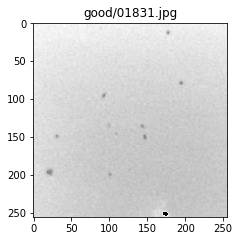

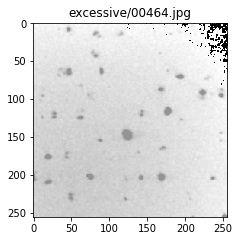

In [18]:
## 오분류된 샘플들을 확인해보자.

def show_sample_images(dataset, sample_indexes, max_limit=12):
    n = len(sample_indexes)
    n_row = min(math.ceil(n / 4), max_limit / 4)
    
    fig = plt.figure(figsize=(16, min(4 * n_row, 15)))
    for i, idx in enumerate(sample_indexes):
        if i >= max_limit:
            return
        
        image, _, _ = dataset[idx]
        path = dataset.imgs[idx][0]

        ax = fig.add_subplot(n_row, 4, i + 1)
        ax.imshow(image.permute(1,2,0)*std + mean)

        ax.set_title(os.path.basename(os.path.dirname(path)) + '/' + os.path.basename(path))
    
    
show_sample_images(test_dataset, evaluators['incorrect'].get_incorrects('good', 'excessive', ))
show_sample_images(test_dataset, evaluators['incorrect'].get_incorrects('excessive', 'short', ))